# Assignment 1: Predicting Absenteeism
### Workforce Analytics
#### Group 10
 - Adrien Talbot, 01817798
 - Callum Fenn Macalister, 01748909
 - Ilias Mylonas, 01770605
 - Paolo Cristini, 01800434
 - Marios Zoulias 01766825,
 - Kostas Paganopoulos 01769789,

In [1]:
# Standard libraries
import numpy as np
import random
from datetime import datetime, timedelta
from tqdm import tqdm
from scipy.spatial import ConvexHull
from collections import Counter
import pandas as pd
pd.set_option('display.max_colwidth', -1)

# Plotting libraries
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from matplotlib import style, pyplot as plt
import seaborn as sns
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

# Machine learning preprocessing libraries
from sklearn import preprocessing, metrics
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import tree
from sklearn.tree.export import export_text
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.utils import shuffle

# Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors

# Clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances

C:\Users\Callum\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning:

The sklearn.tree.export module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.



In [65]:
#Importing and fixing the datasets
df_comments_by_employees_in_anonymous_forum = pd.read_csv('comments_by_employees_in_anonymous_forum.csv')
df_comments_by_employees_in_anonymous_forum['commentDate'] = pd.to_datetime(df_comments_by_employees_in_anonymous_forum['commentDate']).dt.strftime('%m/%d/%Y')
df_comments_by_employees_in_anonymous_forum['commentDate'] = pd.to_datetime(df_comments_by_employees_in_anonymous_forum['commentDate'])

df_employeeAbsenteeism = pd.read_csv('employeeAbsenteeism.csv')
df_employeeAbsenteeism['absence_length'] = df_employeeAbsenteeism.apply (lambda row: (datetime.strptime(row['to'], '%m/%d/%y %H:%M') - datetime.strptime(row['from'],'%m/%d/%y %H:%M')).days , axis = 1)
df_employeeAbsenteeism = df_employeeAbsenteeism[df_employeeAbsenteeism['absence_length'] != 0]
df_employeeAbsenteeism['from'] = pd.to_datetime(df_employeeAbsenteeism['from']).dt.strftime('%m/%d/%Y')
df_employeeAbsenteeism['from'] = pd.to_datetime(df_employeeAbsenteeism['from'])
df_employeeAbsenteeism['to'] = pd.to_datetime(df_employeeAbsenteeism['to']).dt.strftime('%m/%d/%Y')
df_employeeAbsenteeism['to'] = pd.to_datetime(df_employeeAbsenteeism['to'])

df_commentinteractions = \
    pd.read_csv('commentInteractions.csv')
df_commentinteractions['actionDate'] = \
    pd.to_datetime(df_commentinteractions['actionDate']).dt.strftime('%m/%d/%Y')
df_commentinteractions['actionDate'] = \
    pd.to_datetime(df_commentinteractions['actionDate'])

df_lastParticipationExists = pd.read_csv('lastParticipationExists.csv', na_values = 'null')
df_lastParticipationExists['deletedOn'] = \
    pd.to_datetime(df_lastParticipationExists['deletedOn']).dt.strftime('%m/%d/%Y')
df_lastParticipationExists['deletedOn'] = \
    pd.to_datetime(df_lastParticipationExists['deletedOn'])

df_votes  = pd.read_csv('votes.csv')

final_dataset = pd.DataFrame(df_votes['employee'].unique(), columns = ['employee']) #first adding the Employee Id's who vote


# Part I: Exploratory Data Analysis

### 1.1 Votes
The votes dataset contains information for each employee when answering the following question: "How happy are you today?" Votes go from 1 to 4 (1 being very bad and 4 very good).

In [32]:
df_votes['voteDate'] = pd.to_datetime(df_votes['voteDate']).dt.date
df_votes['year'] = pd.DatetimeIndex(df_votes['voteDate']).year
df_votes['month'] = pd.DatetimeIndex(df_votes['voteDate']).month
df_votes.head()

employee companyAlias    voteDate  vote  year  month
0      2ER           C1  2017-05-03     1  2017      5
1      DaW           C1  2017-05-03     2  2017      5
2      5ER           C1  2017-05-03     2  2017      5
3      yvK           C1  2017-05-03     2  2017      5
4      JzX           C1  2017-05-03     2  2017      5

We observe that there are 472 unique employees in the dataset

In [5]:
len(list(df_votes['employee'].unique()))

472

The average vote is approximately 2.8: 

In [6]:
df_votes['vote'].mean()

2.8495797218114083

We will now look at the total number of votes per day from 2017 to 2019 (two-year data):

In [7]:
df_votes['voteDate'].min(), df_votes['voteDate'].max()

(datetime.date(2017, 5, 3), datetime.date(2019, 3, 11))

In [8]:
sum_daily_votes = pd.DataFrame(df_votes.groupby('voteDate')['vote'].sum())
sum_daily_votes = sum_daily_votes.reset_index()
sum_daily_votes.rename(columns = {'vote':'sum daily votes', 'voteDate' : 'all years'}, inplace = True)

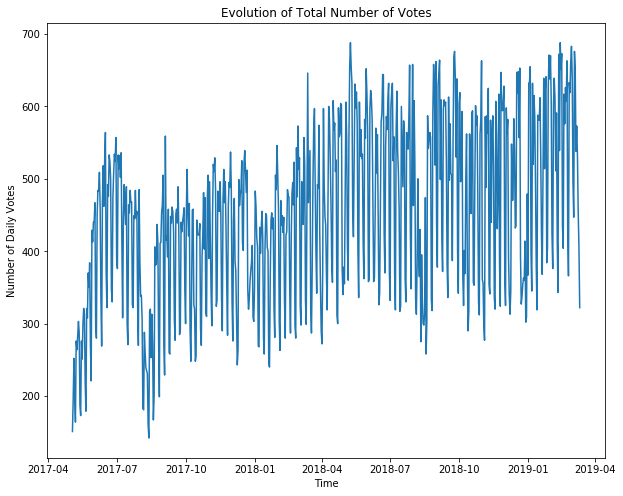

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(sum_daily_votes['all years'], sum_daily_votes['sum daily votes'])

ax.set(xlabel='Time', ylabel='Number of Daily Votes',
       title='Evolution of Total Number of Votes')
ax.grid()
plt.grid(b=None)

plt.show()

We see that the the total number of votes is gradually increasing over the years. It could be result of the platform becoming more attractive the employees. We also want to have a look at the evolution of number of votes for each vote category (very bad, bad, good and very good):

In [11]:
df_votes_very_bad = df_votes[df_votes['vote'] == 1]
df_votes_bad = df_votes[df_votes['vote'] == 2]
df_votes_good = df_votes[df_votes['vote'] == 3]
df_votes_very_good = df_votes[df_votes['vote'] == 4]

In [12]:
sum_very_bad_votes = pd.DataFrame(df_votes_very_bad.groupby('voteDate')['vote'].sum())
sum_very_bad_votes = sum_very_bad_votes.reset_index()
sum_very_bad_votes.rename(columns = {'vote':'Count Very Bad Votes', 'voteDate' : 'all years'}, inplace = True)

sum_bad_votes = pd.DataFrame(df_votes_bad.groupby('voteDate')['vote'].sum())
sum_bad_votes = sum_bad_votes.reset_index()
sum_bad_votes.rename(columns = {'vote':'Count Bad Votes', 'voteDate' : 'all years'}, inplace = True)


sum_good_votes = pd.DataFrame(df_votes_good.groupby('voteDate')['vote'].sum())
sum_good_votes = sum_good_votes.reset_index()
sum_good_votes.rename(columns = {'vote':'Count Good Votes', 'voteDate' : 'all years'}, inplace = True)

sum_very_good_votes = pd.DataFrame(df_votes_very_good.groupby('voteDate')['vote'].sum())
sum_very_good_votes = sum_very_good_votes.reset_index()
sum_very_good_votes.rename(columns = {'vote':'Count Very Good Votes', 'voteDate' : 'all years'}, inplace = True)

In [13]:
df_bad_and_verybad = sum_very_bad_votes.merge(sum_bad_votes, on = 'all years')
df_good_very_good = sum_good_votes.merge(sum_very_good_votes, on = 'all years')
df_all_categories = df_bad_and_verybad.merge(df_good_very_good, on ='all years')

The following dataframe contains the count of votes broken down by level of happiness / category:

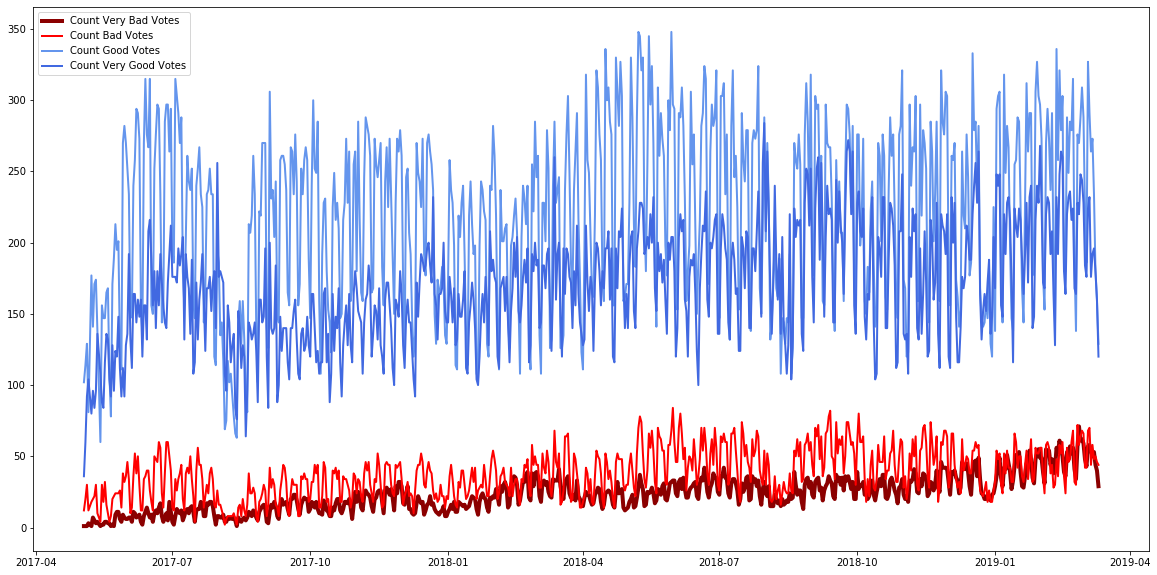

In [16]:
plt.figure(figsize=(20,10))
plt.plot('all years', 'Count Very Bad Votes', data=df_all_categories, color='darkred', linewidth=4,  label="Count Very Bad Votes")
plt.plot('all years', 'Count Bad Votes', data=df_all_categories, marker='', color='red', linewidth=2,  label="Count Bad Votes")
plt.plot('all years', 'Count Good Votes', data=df_all_categories, marker='', color='cornflowerblue', linewidth=2, label="Count Good Votes")
plt.plot('all years', 'Count Very Good Votes', data=df_all_categories, marker='', color='royalblue', linewidth=2, label="Count Very Good Votes")
plt.legend()
plt.show()

By looking at the plot above, we see that the number of all vote types gradually increase overall.

The following plot shows the distribution of number of votes across the four voting categories :

In [17]:
df_distribution_vote = pd.DataFrame(df_votes.groupby('vote')['employee'].count().reset_index())

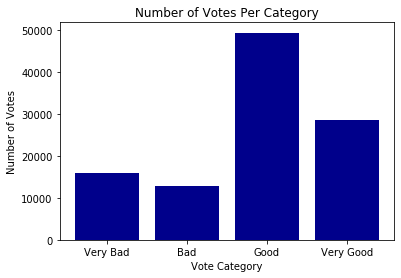

In [18]:
x =  ["Very Bad", 'Bad', 'Good', 'Very Good']
energy = [15983,12893,49439,28609]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, energy, color='darkblue')
plt.xlabel("Vote Category")
plt.ylabel("Number of Votes")
plt.title("Number of Votes Per Category")

plt.xticks(x_pos, x)

plt.show()

In [19]:
df_good_votes = df_distribution_vote[df_distribution_vote["vote"] == 3] 
df_good_votes['employee'].sum() / df_distribution_vote['employee'].sum()

0.46276466293502067

Good votes represent 46 percent of all votes and it shows that almost half of the platform users would answer positively when being asked if they are happy today.

We will now look at the evolution of the daily average vote level:

In [20]:
average_daily_votes = pd.DataFrame(df_votes.groupby('voteDate')['vote'].mean())
average_daily_votes = average_daily_votes.reset_index()
average_daily_votes.rename(columns = {'vote':'average daily vote', 'voteDate' : 'all years'}, inplace = True)

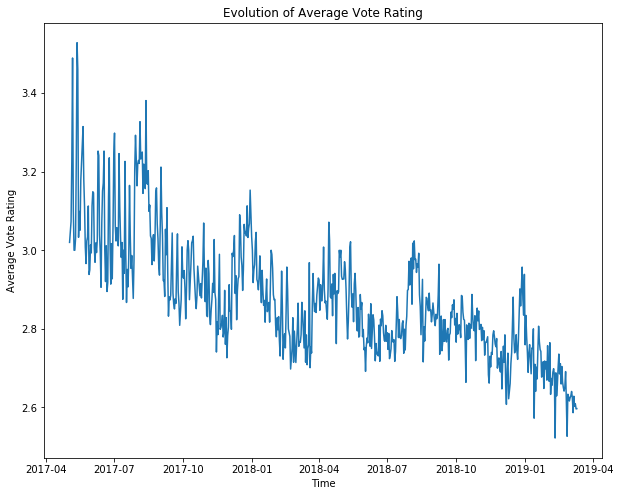

In [21]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(average_daily_votes['all years'], average_daily_votes['average daily vote'])

ax.set(xlabel='Time', ylabel='Average Vote Rating',
       title='Evolution of Average Vote Rating')
ax.grid()
plt.grid(b=None)

plt.show()

Interestingly we see that the average vote ratings decrease over time from 3 to 2.6 (13 % decrease from April 2017 to March 2019) which could mean that the employees are becoming less happy. It could be the result of the increase of users voting badly.

To find out what is causing such a decrease, we need to look at the proportional increase in employees voting bad vs employees giving good ratings.

In order to have a better overall view in the voting categories, we will group the bad and very bad votes into one category ("Bad Votes") and we will do the same for good and very good votes ("Good Votes") and calculate the total count for each:

In [22]:
df_all_categories['Sum Good Votes'] = df_all_categories['Count Good Votes'] +df_all_categories['Count Very Good Votes']
df_all_categories['Sum Bad Votes'] = df_all_categories['Count Bad Votes'] +df_all_categories['Count Very Bad Votes']

Let's group by month and plot two separate line charts to better see the difference in the increase between good and bad votes from 2007 to 2009:

In [23]:
df_all_categories['all years'] = pd.to_datetime(df_all_categories['all years'])
df_all_categories['Year-Month'] = df_all_categories['all years'].dt.strftime('%Y-%m')

In [24]:
df_good_votes_count_month = pd.DataFrame(df_all_categories.groupby('Year-Month')['Sum Good Votes'].sum()).reset_index()
df_bad_votes_count_month = pd.DataFrame(df_all_categories.groupby('Year-Month')['Sum Bad Votes'].sum()).reset_index()
df_good_votes_count_month.drop(df_good_votes_count_month.tail(1).index,inplace=True)
df_bad_votes_count_month.drop(df_bad_votes_count_month.tail(1).index,inplace=True)

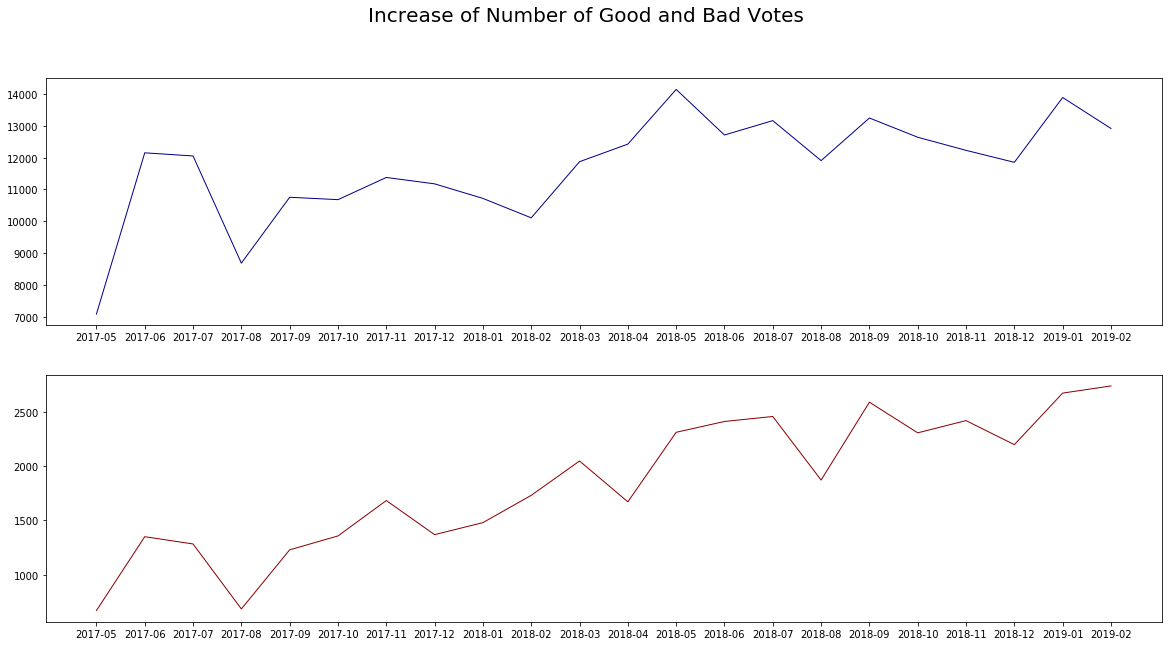

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
fig.suptitle('Increase of Number of Good and Bad Votes', size  = 20)

ax1.plot(df_good_votes_count_month['Year-Month'], df_good_votes_count_month['Sum Good Votes'], color='darkblue', linewidth=1 )
ax2.plot(df_bad_votes_count_month['Year-Month'], df_bad_votes_count_month['Sum Bad Votes'], color='darkred', linewidth=1)


There is a 82 percent increase in the number of good votes:

In [26]:
number_good_votes_first_period = df_good_votes_count_month[df_good_votes_count_month['Year-Month'] == '2017-05']['Sum Good Votes'][0]
number_good_votes_last_period = df_good_votes_count_month[df_good_votes_count_month['Year-Month'] == '2019-02']['Sum Good Votes'][21]

change_good = ((number_good_votes_last_period - number_good_votes_first_period) / number_good_votes_first_period)
change_good

0.8245762711864407

And a 310 percent increase in the number of bad votes from May 2007 to February 2019:

In [27]:
number_bad_votes_first_period = df_bad_votes_count_month[df_bad_votes_count_month['Year-Month'] == '2017-05']['Sum Bad Votes'][0]
number_bad_votes_last_period = df_bad_votes_count_month[df_bad_votes_count_month['Year-Month'] == '2019-02']['Sum Bad Votes'][21]

change_bad = ((number_bad_votes_last_period - number_bad_votes_first_period) / number_bad_votes_first_period)
change_bad

3.104790419161677

We can see that there is a much bigger proportional increase (310%) in the bad votes than in good votes (82%), which explains why there is a decrease of the average vote. Thus, the decrease in average votes (c.13%) is due to the fact that the increase of employees voting negatively is greater than the increase of employees voting positively from 2017 to 2019.

### 1.2 Comments and Interactions

In [34]:
df_commentinteractions['Year-Month'] = df_commentinteractions['actionDate'].dt.strftime('%Y-%m')
df_comments_by_employees_in_anonymous_forum['Year-Month'] = df_comments_by_employees_in_anonymous_forum['commentDate'].dt.strftime('%Y-%m')

There are exactly 305 users who commented at least once:

In [35]:
len(list(df_comments_by_employees_in_anonymous_forum['employee'].unique()))

305

The average comment length is 168 words:

In [36]:
df_comments_by_employees_in_anonymous_forum['commentLength'].mean()

168.5183359621451

Let's have a look at the evolution in the number of monthly positive and negative interactions from 2017 to 2019:

In [38]:
df_likes_month = pd.DataFrame(df_comments_by_employees_in_anonymous_forum.groupby('Year-Month')['likes'].sum().reset_index())
df_dislikes_month = pd.DataFrame(df_comments_by_employees_in_anonymous_forum.groupby('Year-Month')['dislikes'].sum().reset_index())
df_interactions_month = df_likes_month.merge(df_dislikes_month, on = 'Year-Month')
df_interactions_month.head()

Year-Month  likes  dislikes
0    2017-05   4004      1170
1    2017-06   5845      1839
2    2017-07   2565      1671
3    2017-08   1026       441
4    2017-09   3179      1297

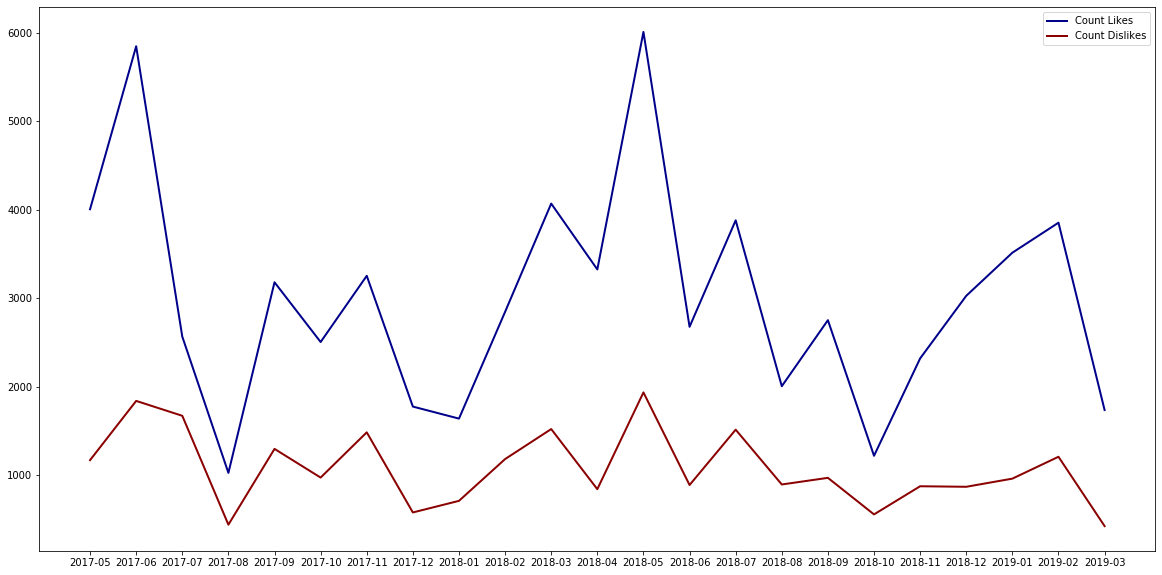

In [39]:
plt.figure(figsize=(20,10))
plt.plot('Year-Month', 'likes', data=df_interactions_month, color='darkblue', linewidth=2,  label="Count Likes")
plt.plot('Year-Month', 'dislikes', data=df_interactions_month, marker='', color='darkred', linewidth=2,  label="Count Dislikes")
plt.legend()

In [40]:
df_interactions_month['likes'].mean()

3000.391304347826

In [41]:
df_interactions_month['dislikes'].mean()

1078.5652173913043

We observe that the monthly number of likes is greater than the number of dislikes (monthly average of 3000 comments v. 1078), which shows that user are generally interacting positively to comments. Moreover,  we see that there is a peak in the number of likes and dislikes when the platform is being introduced in 2017, which shows there is a lot of activity at the beginning maybe because the employees are enthusiastic about the platform. 

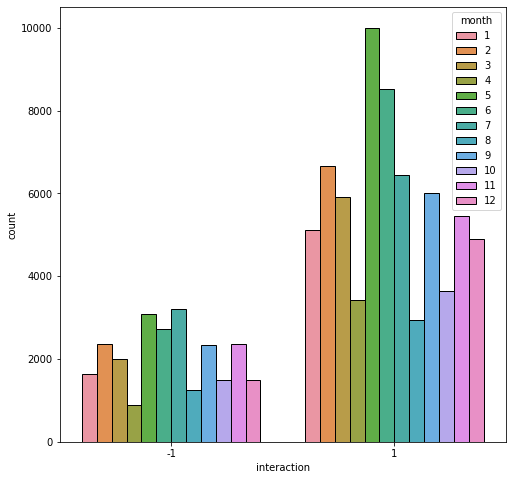

In [42]:
plt.figure(figsize = (8, 8))
df_commentinteractions['month'] = pd.DatetimeIndex(df_commentinteractions['actionDate']).month
sns.countplot(x = 'interaction', hue = 'month', ec = 'black', data = df_commentinteractions)

Therefore, we can see that interactions are more or less equally distributed among all months, but a lower number of interactions occur during April and August. A reason for that might be that employees do not log in to the app so often during those months, probably due to vacations.

We can also plot the evolution of the number of comments during the same period:

In [43]:
df_comments_month = pd.DataFrame(df_comments_by_employees_in_anonymous_forum.groupby('Year-Month')['commentId'].count().reset_index())

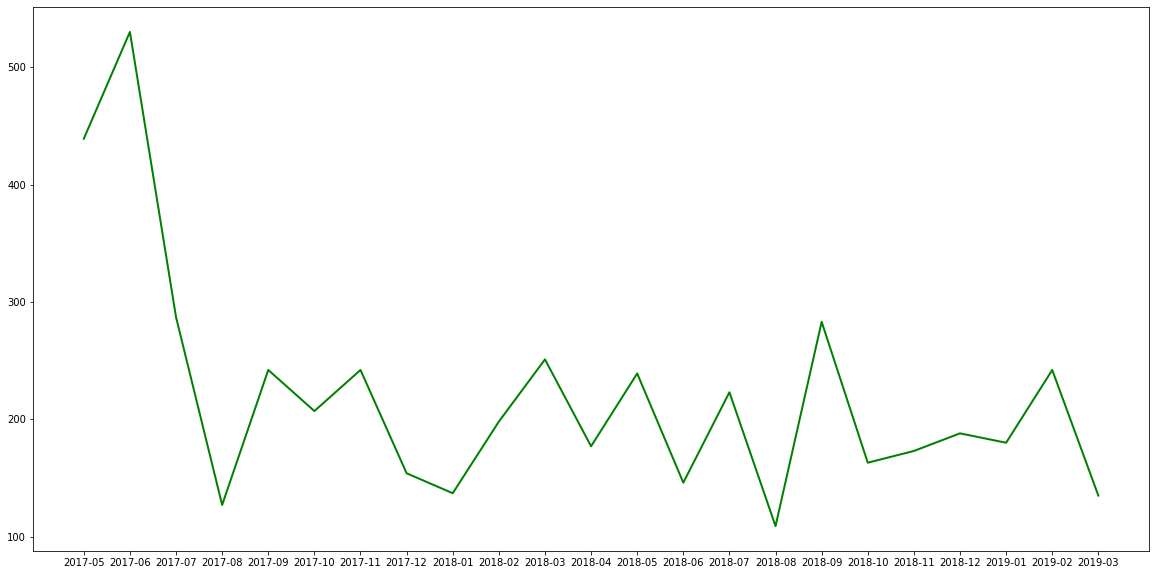

In [44]:
plt.figure(figsize=(20,10))
plt.plot('Year-Month', 'commentId', data=df_comments_month, color='green', linewidth=2,  label="Count Comments")
plt.show()

We can see that there is a sharp increase in the number of comments and then it stabilizes at around 200 comments per month. We could believe the sharp initial happened because the platform was introduced at that time and employees were eager to try it out.

Let's further deep dive in the comment types by finding which comment types are the most frequent:

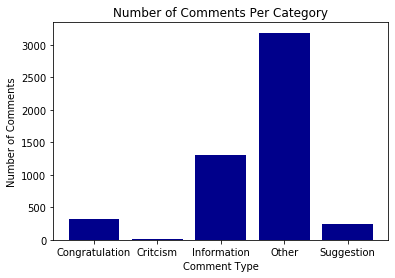

In [46]:
df_comment_types = pd.DataFrame(df_comments_by_employees_in_anonymous_forum.groupby('feedbackType')['commentId'].count().reset_index())

x =  ["Congratulation", 'Critcism', 'Information', 'Other', 'Suggestion']
energy = [325,16,1302,3188,241]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, energy, color='darkblue')
plt.xlabel("Comment Type")
plt.ylabel("Number of Comments")
plt.title("Number of Comments Per Category")

plt.xticks(x_pos, x)

plt.show()

The majority of comments are "Other" type with 3188 comments in total but we do not know exactly the exact type of those comments. Additionally, "Information" is the second category with most comments (1302). As for "Criticism" type, there are only 16 of them. We could believe that users are reluctant to post negative comments on the platform. 

Now, let's check if there is any correlation between likes, dislikes and length of comments. We draw a heat map between likes, dislikes and length of comments:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1b7efb50>,
      dtype=object)

<Figure size 720x720 with 0 Axes>

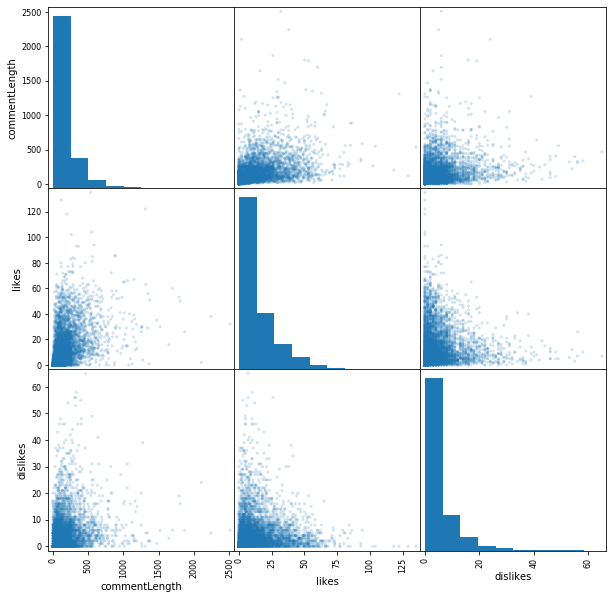

In [47]:
from pandas.plotting import scatter_matrix

corr_matrix = df_comments_by_employees_in_anonymous_forum[['commentLength', 'likes', 'dislikes']].corr()
plt.figure(figsize = (10, 10))
scatter_matrix(df_comments_by_employees_in_anonymous_forum, alpha = 0.2, figsize = (10, 10))

Therefore no significance correlation between likes, dislikes and length of comments is observed.


### 1.3 Absenteeism

In [48]:
# Fixing initial and final dates
InitialDate = np.min(df_employeeAbsenteeism['from'])
FinalDate = np.max(df_employeeAbsenteeism['to'])
print(InitialDate)
print(FinalDate)

2018-06-01 00:00:00
2018-10-31 00:00:00


In [49]:
# Creating time series reference
DateIndex = pd.date_range(InitialDate,FinalDate)

#### 1.3.1 Absenteeism by Time

In [51]:
# Calculating absents per day
NAbsent = np.zeros((np.shape(DateIndex)[0],1))
for index, day in enumerate(DateIndex): NAbsent[index] = \
    df_employeeAbsenteeism.loc[(df_employeeAbsenteeism['from'] <= day) & \
        (df_employeeAbsenteeism['to'] >= day), 'employee'].count()

NAbsent[NAbsent==0] = None

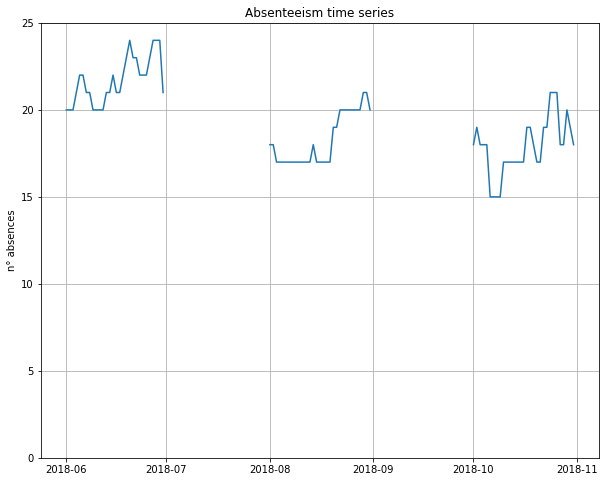

In [52]:
# Plotting
plt.figure(figsize = (10,8))
plt.plot(DateIndex, NAbsent)
plt.ylim((0,25))
plt.title('Absenteeism time series')
plt.ylabel('n° absences')
plt.grid(True)

In [53]:
nAbsentEmployees=df_employeeAbsenteeism.employee.nunique()
nAbsentEmployees

57

The very first glance at absenteeism is along the dimension of time. What is evident is the very small available sample, in fact, absenteeism has been recorded just for the month of **June**, **August** and **October** 2018, even though the database provides data for a longer period. Overall, the number of absences are roughly around **15 to 25 per month**, but with differences in mean for the three months displayed. The number of absent employees is **57** that suggests a sort of repetitiveness in the behavious of some employees.

#### 1.3.2 Absenteeism by Length

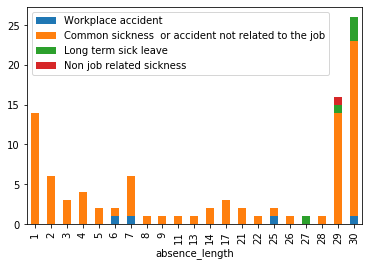

In [54]:
Reasons = df_employeeAbsenteeism['reason'].unique()
LengthAbsent = df_employeeAbsenteeism.groupby('absence_length').count()[['employee']]    

# Calculating 
for reason in Reasons:
    CuDF = \
        df_employeeAbsenteeism.loc[df_employeeAbsenteeism.reason == \
                                   reason].groupby('absence_length').count()[['employee']]
    CuDF.rename(columns={'employee': reason}, inplace = True)
    LengthAbsent = pd.merge(LengthAbsent, CuDF, how = 'left', on = 'absence_length').fillna(0)

# Plotting
LengthAbsent.loc[:,Reasons].plot.bar(stacked=True)

The frequency distribution of the absenteeism lenght shows that is more likely to observe a short, less than 7 days, or very long absence periods, greater than 25, while in the middle of these two categories absenteeism is rarer. The dominant reason for absenteeism is common sickness or accidents not regarding job.

### 1.4 Absenteeism and Voting

#### 1.4.1 Absent Employees not Voting

In [55]:
nNoVotingAbsents = pd.merge(df_employeeAbsenteeism, df_votes, how = 'left', on = 'employee').fillna(0)
nNoVotingAbsents = nNoVotingAbsents.loc[nNoVotingAbsents.vote==0].count()[['employee']]
nNoVotingAbsents

employee    6
dtype: int64

Among the 57 employees absents during the sample period, around **10.5%** (6 people) did not use the voting system.

#### 1.4.2 Absent Employees Voting

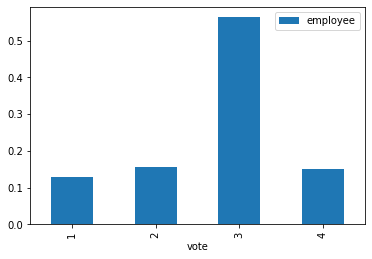

In [56]:
VotingSystem = pd.merge(df_employeeAbsenteeism, df_votes, on = 'employee')
VotingSystem = VotingSystem.groupby('vote').count()[['employee']]
nVotingAmongAbsents = np.sum(VotingSystem.employee)
Prop = VotingSystem/nVotingAmongAbsents
Prop.plot.bar()

Quite surprisingly, more than a half of the absent employeers that vote, espress a vote of 3, meaning "Good", among 4 option from 1 ("Very Bad") to 4 ("Very good").

### 1.5 Absenteeism and Comments

#### 1.5.1 Absent Employees not Commenting

In [58]:
nNoCommentAbsents = pd.merge(df_employeeAbsenteeism,
                             df_comments_by_employees_in_anonymous_forum, 
                             how = 'left', 
                             on = 'employee').fillna(0)
nNoCommentAbsents = nNoCommentAbsents.loc[nNoCommentAbsents.feedbackType==0].count()[['employee']]
nNoCommentAbsents

employee    27
dtype: int64

Among the 57 employees absents during the sample period, around **47.4%** (27 people) did not use the comments platform.

#### 1.5.2 Absent Employees Commenting

In [59]:
CommentSystem = pd.merge(df_employeeAbsenteeism, 
                         df_comments_by_employees_in_anonymous_forum, 
                         on = 'employee')

In [60]:
#CommentSystem: 
CS_1 = CommentSystem.groupby('feedbackType').count()[['employee']]
nCommentAmongAbsents = np.sum(CS_1.employee)
CS_1.employee = CS_1.employee / nCommentAmongAbsents

CS_2 = CommentSystem.groupby('feedbackType').sum()[['likes', 'dislikes']]
CS_2.head(5)

CS = pd.merge(CS_1, CS_2, on = 'feedbackType')
CS['likes reaction'] = CS.employee * ( CS.likes / (CS.likes + CS.dislikes) )
CS['dislikes reaction'] = CS.employee * ( CS.dislikes / (CS.likes + CS.dislikes) )
CS.index.rename('Feedback type proportion', inplace = True)

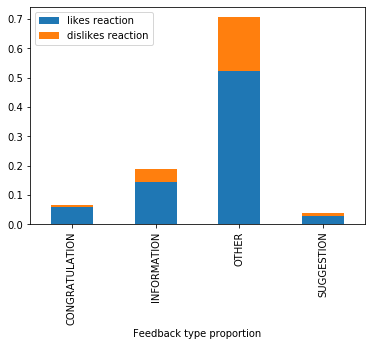

In [61]:
CS.loc[:,['likes reaction','dislikes reaction']].plot.bar(stacked=True)

Around **70%** of the absent employeers that comment, espress a generic feedback. Dislikes do not represent a crucial proportion for any specific type of feedback.

### 1.6 Present Employees

An important comparison has been made looking at the employees' behavior along the dimension already analyzed for absent employees.

#### 1.6.1 Present Employees Voting

In [66]:
# Identify present employeers
PresentEmployeesList = pd.merge(df_lastParticipationExists, 
                                df_employeeAbsenteeism,
                                how = 'left', 
                                on = 'employee').fillna(0)

PresentEmployeesList = PresentEmployeesList.loc[PresentEmployeesList.reason==0]
nPresentEmployees = np.shape(PresentEmployeesList)[0]

In [ ]:
VotingSystemPre = pd.merge(PresentEmployeesList, df_votes, on = 'employee')
VotingSystemPre = VotingSystemPre.groupby('vote').count()[['employee']]
nVotingAmongPresent = np.sum(VotingSystemPre.employee)
Prop = VotingSystemPre/nVotingAmongPresent
Prop.plot.bar()

For not-absent employees the category "Good" is preeminent, but with less relevance if compared with absenteeism results.

#### 1.6.2 Present Employees not Voting

In [68]:
nNoVotingPresent = pd.merge(PresentEmployeesList, df_votes, how = 'left', on = 'employee').fillna(0)
nNoVotingPresent = nNoVotingPresent.loc[nNoVotingPresent.vote==0].count()[['employee']]
nNoVotingPresent / nPresentEmployees

employee    0.018779
dtype: float64

The percentage of non voting among the present employees is much lower than the absent ones: less then **2%** did not use the voting system.

### 1.7 Present Employees and Comments

#### 1.7.1 Present Employees not Commenting

In [71]:
nNoCommentPresent = pd.merge(PresentEmployeesList,
                             df_comments_by_employees_in_anonymous_forum, 
                             how = 'left', 
                             on = 'employee').fillna(0)
nNoCommentPresent = nNoCommentPresent.loc[nNoCommentPresent.feedbackType==0].count()[['employee']]
nNoCommentPresent/nPresentEmployees

employee    0.382629
dtype: float64

Non-absent employees who are not commenting represent approximately **38.3%** of all the non-absent employees, not far from the absent sub-sample results.

#### 1.7.2 Present Employees Commenting

In [72]:
CommentSystemPre = pd.merge(PresentEmployeesList, 
                         df_comments_by_employees_in_anonymous_forum, 
                         on = 'employee')

In [73]:
#CommentSystem = 
CS_1 = CommentSystemPre.groupby('feedbackType').count()[['employee']]
nCommentAmongPresent = np.sum(CS_1.employee)
CS_1.employee = CS_1.employee / nCommentAmongPresent

CS_2 = CommentSystemPre.groupby('feedbackType').sum()[['likes', 'dislikes']]
CS_2.head(5)

CS = pd.merge(CS_1, CS_2, on = 'feedbackType')
CS['likes reaction'] = CS.employee * ( CS.likes / (CS.likes + CS.dislikes) )
CS['dislikes reaction'] = CS.employee * ( CS.dislikes / (CS.likes + CS.dislikes) )
CS.index.rename('Feedback type proportion', inplace = True)

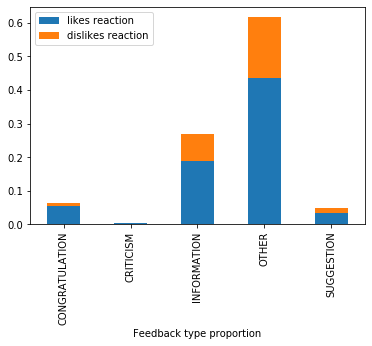

In [74]:
CS.loc[:,['likes reaction','dislikes reaction']].plot.bar(stacked=True)

Surprisingly, among the other feedback type, "Criticism" appears but in a proportion that is non-visible.

# Part II: Absenteeism Prediction

In [3]:
#Function to help find whether an employee was absent between a period
def was_he_absent(period_start, period_end, employee):
    
    absent1 = df_employeeAbsenteeism[ df_employeeAbsenteeism['from'] <= period_start] 
    absent1 = absent1[ absent1['to'] >= period_start]    
 
    #catch all scenarios (eg we look in period 15-30 october and he is sick from 26-28 october)
    absent2 = df_employeeAbsenteeism[ df_employeeAbsenteeism['from'] <= period_end] 
    absent2 = absent2[ absent2['from'] >= period_start]  
    absent2 = absent2[ absent2['to'] <= period_end]    
    
    if employee in list(absent2['employee']) or employee in list(absent1['employee']):
        return 1
    else:
        return 0



#Add vote related metrics to the final Dataset for a period
def vote_analysis(period):
    
    #get the votes to the periods we want
    votes_period = df_votes[ df_votes['voteDate'] >= periods_start[period]]
    votes_period = votes_period[ votes_period['voteDate'] <= periods_end[period]]
    
    #now delete the vote columns not needed
    del votes_period['companyAlias']
    del votes_period['voteDate']

    #get the comments to the periods we want
    comments_period = df_comments_by_employees_in_anonymous_forum[ df_comments_by_employees_in_anonymous_forum['commentDate'] >= periods_start[period]]
    comments_period = comments_period[ comments_period['commentDate'] <= periods_end[period]]

    #now delete the comment columns not needed
    del comments_period['commentId']
    del comments_period['companyAlias']
    del comments_period['commentDate']
    del comments_period['feedbackType']
    
    #metric 1
    count_per_employee = votes_period.groupby('employee').count()[['vote']] 
    count_per_employee.columns = ['No_of_Votes']
    
    #metric 2
    average_vote_per_employee = round(votes_period.groupby('employee').mean()[['vote']], 2) 
    average_vote_per_employee.columns = ['Average_value_Votes']
    
    #metric 3
    emotional_stability = votes_period.groupby('employee').agg([
    ('max_vote','max'), 
    ('min_vote','min')
    ])
        
    emotional_stability['emotional_stability'] = emotional_stability.apply(lambda row: row['vote','max_vote'] - row['vote','min_vote'], axis = 1)
    del emotional_stability['vote']
    
    #metric 4
    comment_count = comments_period.groupby('employee').count()
    comment_count = comment_count[['likes']] #it is the same if you keep the likes or dislikes as the count is similar
    comment_count.columns = ['No_of_Comments']
    comment_likes = comments_period.groupby('employee').sum()[['likes']]
    comment_dislikes = comments_period.groupby('employee').sum()[['dislikes']]
    comment_length = comments_period.groupby('employee').mean()[['commentLength']]
    comment_length = round(comment_length,2)
    comment_info = pd.merge(comment_count, comment_likes, on='employee', how='inner')
    comment_info = pd.merge(comment_info, comment_dislikes, on='employee', how='inner')
    comment_info = pd.merge(comment_info, comment_length, on='employee', how='inner')
    
    #now add the metrics to final dataset
    dataset = pd.merge(final_dataset, count_per_employee, on='employee', how='left').fillna('NA') #metric 1
    dataset = pd.merge(dataset, average_vote_per_employee, on='employee', how='left').fillna('NA') #metric 2
    dataset = pd.merge(dataset, emotional_stability, on='employee', how='left').fillna('NA') #metric 3
    dataset = pd.merge(dataset, comment_info, on='employee', how='left').fillna('NA') #metric 3
    
    dataset["Absent_next_period"] = 'NA'
    dataset["Current_Period"] = '  FROM  ' + str(periods_start[period]) +'  TO  ' + str(periods_end[period])
    dataset.columns = ['employee','No_of_Votes','Average_value_Votes','Emotional_stability','No_of_Comments','Likes_from_others','Dislikes_from_others','Average_comment_length','Absent_next_period','Current_Period']
    
    #Now let's find if this employee was absent during this period 0 or 1
    dataset["Absent_next_period"] = dataset.apply(lambda row: was_he_absent(periods_start[period+1],periods_end[period+1], row['employee']), axis = 1)
    
    return dataset


In [4]:
#the last period will not be included in the final dataset
periods_start = ['2018-05-15', '2018-06-01', '2018-06-16', '2018-07-15', '2018-08-01', '2018-08-16', '2018-09-15', '2018-10-01', '2018-10-16' ]
periods_end   = ['2018-05-31', '2018-06-15', '2018-06-30', '2018-07-31', '2018-08-15', '2018-08-31', '2018-09-30', '2018-10-15', '2018-10-31' ]
#we have to remove from final dataset the periods |'2018-06-16' to '2018-06-30'| |'2018-08-16' to '2018-08-31'| because it 
#includes 1st wrong and 2nd useless data (We needed them in order to find absenteism for the period right before them)

In [5]:
workforce_dataset = pd.DataFrame(columns=['employee','No_of_Votes','Average_value_Votes','Emotional_stability','No_of_Comments','Likes_from_others','Dislikes_from_others','Average_comment_length','Absent_next_period','Current_Period'])


for period in range(0,len(periods_start)-1):
    new_data = vote_analysis(period)
    workforce_dataset = pd.concat([workforce_dataset, new_data], ignore_index=True)
    print(period)#out of 7 (and then of course remove 2 periods)

#SOS There are employees who were completely inactive in voting during the periods we look for 
#(but were active in other periods) .... So their metrics in this dataset are all NA and absent is 0

#we must remove these periods and 
workforce_dataset = workforce_dataset[workforce_dataset.Current_Period != '  FROM  2018-06-16  TO  2018-06-30']
workforce_dataset = workforce_dataset[workforce_dataset.Current_Period != '  FROM  2018-08-16  TO  2018-08-31']

workforce_dataset.to_csv('workforce_dataset.csv', index=False)

C:\Users\mylon\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


0
1
2
3
4
5
6
7


### 2.1 Load Dataset

In [7]:
all_employees = workforce_dataset.employee.unique().shape[0]

In [8]:
absents = workforce_dataset[workforce_dataset.Absent_next_period==1].employee.unique().shape[0]
non_absents = all_employees-absents
absents

54

We can see that we have only 54 unique employees who were generally absent and 418 who were not absent.

In [9]:
sample_ratio_orig = absents/non_absents

### 2.2 Deal with NA Values
There are a lot of 'NA' values in the dataset and we have to find a way to deal with this problem.
We replace this values with zero since those employees do not use the app.

In [10]:
data_new = workforce_dataset.replace('NA',0)
data_new = data_new.drop(['Emotional_stability'], axis=1)
data_new

employee  No_of_Votes  Average_value_Votes  No_of_Comments  \
0         2ER         15.0                  2.2             1.0   
1         DaW         14.0                  3.0             0.0   
2         5ER         14.0                  1.0             1.0   
3         yvK          0.0                  0.0             0.0   
4         JzX          7.0                  2.0             0.0   
...       ...          ...                  ...             ...   
3771      LA2          0.0                  0.0             0.0   
3772      dQy          0.0                  0.0             0.0   
3773      ZGa          0.0                  0.0             0.0   
3774      Nrr          0.0                  0.0             0.0   
3775      AER          0.0                  0.0             0.0   

      Likes_from_others  Dislikes_from_others  Average_comment_length  \
0                  53.0                   5.0                   228.0   
1                   0.0                   0.0                     0.0   
2                  49.0                  11.0                   316.0   
3                   0.0                   0.0                     0.0   
4                   0.0                   0.0                     0.0   
...                 ...                   ...                     ...   
3771                0.0                   0.0                     0.0   
3772                0.0                   0.0                     0.0   
3773                0.0                   0.0                     0.0   
3774                0.0                   0.0                     0.0   
3775                0.0                   0.0                     0.0   

      Absent_next_period                      Current_Period  
0                      1    FROM  2018-05-15  TO  2018-05-31  
1                      0    FROM  2018-05-15  TO  2018-05-31  
2                      0    FROM  2018-05-15  TO  2018-05-31  
3                      0    FROM  2018-05-15  TO  2018-05-31  
4                      0    FROM  2018-05-15  TO  2018-05-31  
...                  ...                                 ...  
3771                   0    FROM  2018-10-01  TO  2018-10-15  
3772                   0    FROM  2018-10-01  TO  2018-10-15  
3773                   0    FROM  2018-10-01  TO  2018-10-15  
3774                   0    FROM  2018-10-01  TO  2018-10-15  
3775                   0    FROM  2018-10-01  TO  2018-10-15  

[2832 rows x 9 columns]

In [11]:
data_new[data_new.Absent_next_period==1].employee.unique().shape[0]

54

### 2.3 Shuffle and Split the Data into Train, Validate and Test
We want to separate our dataset into a train dataset, a validation dataset and a test dataset.
We will look at the number of unique number of employees we had for each period. 
We want our val and test dataset to have around 20% each of the number of rows of our dataset.

In [12]:
inputs = data_new.drop(["employee","Absent_next_period","Current_Period"],axis="columns")
target = data_new["Absent_next_period"]
target = pd.DataFrame(target)
inputs

No_of_Votes  Average_value_Votes  No_of_Comments  Likes_from_others  \
0            15.0                  2.2             1.0               53.0   
1            14.0                  3.0             0.0                0.0   
2            14.0                  1.0             1.0               49.0   
3             0.0                  0.0             0.0                0.0   
4             7.0                  2.0             0.0                0.0   
...           ...                  ...             ...                ...   
3771          0.0                  0.0             0.0                0.0   
3772          0.0                  0.0             0.0                0.0   
3773          0.0                  0.0             0.0                0.0   
3774          0.0                  0.0             0.0                0.0   
3775          0.0                  0.0             0.0                0.0   

      Dislikes_from_others  Average_comment_length  
0                      5.0                   228.0  
1                      0.0                     0.0  
2                     11.0                   316.0  
3                      0.0                     0.0  
4                      0.0                     0.0  
...                    ...                     ...  
3771                   0.0                     0.0  
3772                   0.0                     0.0  
3773                   0.0                     0.0  
3774                   0.0                     0.0  
3775                   0.0                     0.0  

[2832 rows x 6 columns]

In [13]:
X_train, X_val_test, y_train, y_val_test = train_test_split(inputs,target,test_size=0.4, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test,y_val_test,test_size=0.5,random_state = 42)

In [14]:
X_train.shape[0]

1699

### 2.4 Training Data Imbalance

In [15]:
print(y_train[y_train.Absent_next_period==1].shape[0])
print(y_train[y_train.Absent_next_period==0].shape[0])

77
1622


We can see that we face a situation where the class of interest, namely absent employees, is rare. As a result, a normal classifier would minimises theoverall misclassificationrate, it may perform poorly in identifying the “interesting” cases. For example if we run a decision tree model in this form of the dataset, we would get:

In [16]:
decision_tree = tree.DecisionTreeClassifier(criterion="entropy")
decision_tree = decision_tree.fit(X_train.values, y_train.values)
r = export_text(decision_tree, feature_names=list(X_train.columns))
y_pred = decision_tree.predict(X_val.values)
score = accuracy_score(y_val,y_pred)
print(score)
tn, fp, fn, tp =confusion_matrix(y_val, y_pred).ravel()
print("True positives: Number of absent employees whose absenteeism we predicted =",tp)

0.941696113074205
True positives: Number of absent employees whose absenteeism we predicted = 0


As a result, we need to use an Oversampling method in order to create an equal amount of 
cases in our training dataset.

In [17]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)

X_res = pd.DataFrame(data=X_res,columns=X_train.columns)
y_res= pd.DataFrame(data=y_res,columns=['Absent_next_period'])

print(y_res[y_res.Absent_next_period==1].shape[0])
print(y_res[y_res.Absent_next_period==0].shape[0])

1622
1622


### 2.5 Decision Tree
Train a decision tree using the default settings, and calculate the accuracy of this tree
on the training dataset (resampled) and the validation set.
Then we find the accuracy score and the true positive cases on the test dataset.

In [18]:
decision_tree = tree.DecisionTreeClassifier(criterion="entropy")
decision_tree = decision_tree.fit(X_res.values, y_res.values)
y_pred = decision_tree.predict(X_val.values)
score = accuracy_score(y_val,y_pred)
print('With the default settings of the decision tree (trained on the resampled training dataset), the accuracy score on the validation dataset was',score)
tn, fp, fn, tp =confusion_matrix(y_val, y_pred).ravel()
print('Out of',y_val[y_val.Absent_next_period==1].shape[0],'absences, we predicted correctly',tp)

With the default settings of the decision tree (trained on the resampled training dataset), the accuracy score on the validation dataset was 0.7968197879858657
Out of 26 absences, we predicted correctly 11


#### 2.5.1. Plot Model Accuracy with Respect to Tree Depth

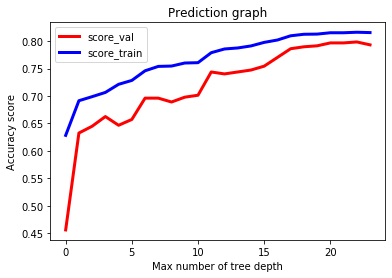

In [19]:
%matplotlib inline
d_dict = {}
scores_train ={}
scores_val = {}
tp_val={}
for d in range(1,25):
    decision_tree = tree.DecisionTreeClassifier(max_depth=d,criterion="entropy")
    d_dict[d] = decision_tree.fit(X_res.values, y_res.values)
    y_pred_val = d_dict[d].predict(X_val)
    scores_val[d] = accuracy_score(y_val, y_pred_val)
    tp_val[d] = confusion_matrix(y_val, y_pred_val)[1,1]
    y_pred_res = d_dict[d].predict(X_res)
    scores_train[d] = accuracy_score(y_res, y_pred_res)
    

plt.figure(1)
plt.plot(list(scores_val.values()),'r',linewidth=3.0,label="score_val")
plt.plot(list(scores_train.values()),'b',linewidth=3.0,label="score_train")
plt.xlabel('Max number of tree depth')
plt.ylabel('Accuracy score')
plt.title('Prediction graph')
plt.legend()

Explanation of the graph: The score train in not increasing after some point reaching a plato, and this is justified by the fact that our decision tree classifier, while classifying our dataset, reaches a point where there are employees with very similar characteristics and some of them are absent while others others are non-absent, and this means that they cannot be classified any more in order to create an overfitting problem as the depth of the tree grows.

In [20]:
for key,value in scores_val.items():
    if value== max(scores_val.values()):
        keep_ac = key
print('Max_depth for accuracy score = ',keep_ac)

for key,value in tp_val.items():
    if value== max(tp_val.values()):
        keep_tp = key
print('Max_depth for true positives = ',keep_tp)

Max_depth for accuracy score =  23
Max_depth for true positives =  1


In [21]:
y_pred_test = d_dict[keep_ac].predict(X_test)
score = accuracy_score(y_test,y_pred_test)
print('Test score for Decision tree =',score)
tn_test, fp_test, fn_test, tp_test =confusion_matrix(y_test, y_pred_test).ravel()
print('Out of',y_test[y_test.Absent_next_period==1].shape[0],'absences, we predicted correctly',tp_test)

Test score for Decision tree = 0.7707231040564374
Out of 26 absences, we predicted correctly 12


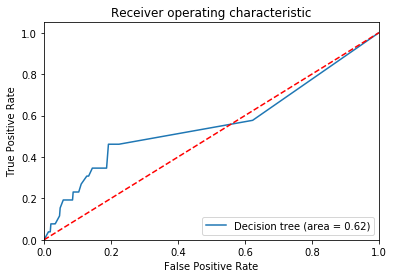

In [22]:
tree_roc_auc = roc_auc_score(y_test, d_dict[keep_ac].predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, d_dict[keep_ac].predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decision tree (area = %0.2f)' % tree_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('treeROC')
plt.show()

#### 2.5.2 Visualizing the Tree
Note: Full tree does not show as too big!

In [23]:
feature_names=list(X_res.columns)
target_names=["Not Absent","Absent"]

# Export as dot file
export_graphviz(d_dict[5], out_file='tree.dot', 
                feature_names = feature_names,
                class_names = target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])


# Display in jupyter notebook
Image(filename = 'tree.png')

### 2.6 Random Forest

We use a random forest tree classifier instead of a bagging tree in order to alleviate the
potential problem of correlation between the predictos.

In [24]:
rforest_clf = RandomForestClassifier(random_state=42, n_estimators=200,max_samples=1000,max_depth=25, bootstrap=True, n_jobs=-1)
rforest_clf = rforest_clf.fit(X_res.values, y_res.values.ravel())

y_pred_val = rforest_clf.predict(X_val)
score = accuracy_score(y_val,y_pred_val)
print('Validation score for Random Forest Classifier =',score)
tn_val, fp_val, fn_val, tp_val=confusion_matrix(y_val, y_pred_val).ravel()
print('Out of',y_val[y_val.Absent_next_period==1].shape[0],'absences, we predicted correctly',tp_val)

y_pred_test = rforest_clf.predict(X_test)
score = accuracy_score(y_test,y_pred_test)
print('Test score for Random Forest Classifier =',score)
tn_test, fp_test, fn_test, tp_test=confusion_matrix(y_test, y_pred_test).ravel()
print('Out of',y_test[y_test.Absent_next_period==1].shape[0],'absences, we predicted correctly',tp_test)


Validation score for Random Forest Classifier = 0.7826855123674912
Out of 26 absences, we predicted correctly 12
Test score for Random Forest Classifier = 0.7654320987654321
Out of 26 absences, we predicted correctly 13


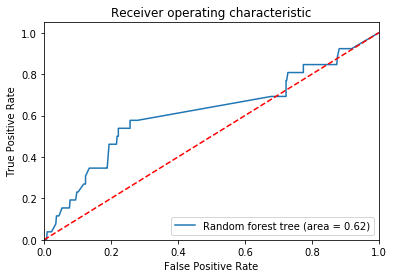

In [25]:
rforest_roc_auc = roc_auc_score(y_test, rforest_clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rforest_clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random forest tree (area = %0.2f)' % tree_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('random_forest_treeROC')
plt.show()

### 2.7 SVM

For the Support Vectro machines, we need to normalize our data so that all features have the same influence on the distance metric.

In [26]:
sc_X = StandardScaler()
X_res_norm = sc_X.fit_transform(X_res)
X_val_norm = sc_X.transform(X_val)
X_test_norm = sc_X.transform(X_test)

In [27]:
from sklearn import svm
svm_clf = svm.SVC(kernel = 'rbf',gamma='auto')
svm_clf.fit(X_res_norm,y_res.values.ravel())

y_pred_val = svm_clf.predict(X_val_norm)
score = accuracy_score(y_val,y_pred_val)
print('Validation score for SVM =',score)
tn_val, fp_val, fn_val, tp_val=confusion_matrix(y_val, y_pred_val).ravel()
print('Out of',y_val[y_val.Absent_next_period==1].shape[0],'absences, we predicted correctly',tp_val)


Validation score for SVM = 0.6554770318021201
Out of 26 absences, we predicted correctly 17


In [28]:
y_pred_test = svm_clf.predict(X_test_norm)
score = accuracy_score(y_test,y_pred_test)
print('Test score for SVM =',score)
tn_test, fp_test, fn_test, tp_test=confusion_matrix(y_test, y_pred_test).ravel()
print('Out of',y_test[y_test.Absent_next_period==1].shape[0],'absences, we predicted correctly',tp_test)


Test score for SVM = 0.5855379188712522
Out of 26 absences, we predicted correctly 19


### 2.8 Logistic Regression

In [29]:
import statsmodels.api as sm
logit_model=sm.Logit(y_res,X_res)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.682087
         Iterations 5
                            Results: Logit
Model:               Logit               Pseudo R-squared:  0.016     
Dependent Variable:  Absent_next_period  AIC:               4437.3817 
Date:                2020-05-04 19:01    BIC:               4473.8890 
No. Observations:    3244                Log-Likelihood:    -2212.7   
Df Model:            5                   LL-Null:           -2248.6   
Df Residuals:        3238                LLR p-value:       4.4132e-14
Converged:           1.0000              Scale:             1.0000    
No. Iterations:      5.0000                                           
----------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------
No_of_Votes            -0.0008   0.0082 -0.1035 0.9176 -0.0169  0.0152
Ave

We see here that we must remove three out of six features because their p value is very high, meaning their beta are not statistically significant different from zero

In [30]:
cols=['Dislikes_from_others', 'No_of_Comments', 'Average_value_Votes'] 
X_reg=X_res[cols]
y_reg=y_res['Absent_next_period']

logit_model=sm.Logit(y_reg,X_reg)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.682320
         Iterations 6
                           Results: Logit
Model:               Logit              Pseudo R-squared: 0.016     
Dependent Variable:  Absent_next_period AIC:              4432.8937 
Date:                2020-05-04 19:01   BIC:              4451.1474 
No. Observations:    3244               Log-Likelihood:   -2213.4   
Df Model:            2                  LL-Null:          -2248.6   
Df Residuals:        3241               LLR p-value:      5.5776e-16
Converged:           1.0000             Scale:            1.0000    
No. Iterations:      6.0000                                         
--------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------
Dislikes_from_others -0.0626   0.0126 -4.9655 0.0000 -0.0873 -0.0379
No_of_Comments        0.2783

What we can infer from this model is that the number of comments is the most imprortant factor (amongst others) that explains the variance of 'Next month absenteeism' variable. Thus the higher the number of comments then the higher the probability that the employee is going to be absent next period

In [31]:
logreg = LogisticRegression()
logreg.fit(X_reg, y_reg)

X_val_reg=X_val[cols]

y_pred_val = logreg.predict(X_val_reg)
score = accuracy_score(y_val,y_pred_val)
print('Accuracy of logistic regression classifier on validation set: ',score)
tn_val, fp_val, fn_val, tp_val=confusion_matrix(y_val, y_pred_val).ravel()
print('Out of',y_val[y_val.Absent_next_period==1].shape[0],'absences, we predicted correctly',tp_val)

Accuracy of logistic regression classifier on validation set:  0.5512367491166078
Out of 26 absences, we predicted correctly 21


In [32]:
X_test_reg=X_test[cols]

y_pred_test = logreg.predict(X_test_reg)
score = accuracy_score(y_test,y_pred_test)
print('Accuracy of logistic regression classifier on Test set: ',score)
tn_test, fp_test, fn_test, tp_test=confusion_matrix(y_test, y_pred_test).ravel()
print('Out of',y_test[y_test.Absent_next_period==1].shape[0],'absences, we predicted correctly',tp_test)

Accuracy of logistic regression classifier on Test set:  0.5167548500881834
Out of 26 absences, we predicted correctly 22


Interestingly the true positive indicator is much higher than other models, for logistic regression, even if acuraccy is too low. Adding more relevant features to the equation would increase the Pseudo R square and would give more accurate results

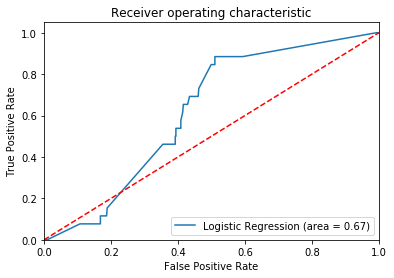

In [33]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test_reg))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test_reg)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### 2.9 Naive Bayes

In [34]:
model = GaussianNB()
model.fit(X_res, y_res.values.ravel())

y_pred_test = model.predict(X_test)
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
score = metrics.accuracy_score(y_test, y_pred_test)
print('Test score for Naive Bayes classifier =',score)
tn_test, fp_test, fn_test, tp_test=confusion_matrix(y_test, y_pred_test).ravel()
print('Out of',y_test[y_test.Absent_next_period==1].shape[0],'absences, we predicted correctly',tp_test)

              precision    recall  f1-score   support

           0       0.98      0.44      0.61       541
           1       0.06      0.81      0.12        26

    accuracy                           0.46       567
   macro avg       0.52      0.62      0.36       567
weighted avg       0.94      0.46      0.58       567

[[238 303]
 [  5  21]]
Test score for Naive Bayes classifier = 0.4567901234567901
Out of 26 absences, we predicted correctly 21


### 2.10 kNN

The kNN needs also scaling in our data since it is based on distances.

In [35]:
model = neighbors.KNeighborsClassifier(n_neighbors = 360, algorithm = 'auto', metric = 'manhattan')
model.fit(X_res_norm, y_res.values.ravel())
y_pred_test = model.predict(X_test_norm)

print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
score = metrics.accuracy_score(y_test, y_pred_test)
print('Test score for k nearest neighbours classifier =', score)
tn_test, fp_test, fn_test, tp_test=confusion_matrix(y_test, y_pred_test).ravel()
print('Out of',y_test[y_test.Absent_next_period==1].shape[0],'absences, we predicted correctly',tp_test)

              precision    recall  f1-score   support

           0       0.99      0.52      0.68       541
           1       0.08      0.88      0.15        26

    accuracy                           0.53       567
   macro avg       0.54      0.70      0.41       567
weighted avg       0.95      0.53      0.66       567

[[280 261]
 [  3  23]]
Test score for k nearest neighbours classifier = 0.5343915343915344
Out of 26 absences, we predicted correctly 23


Max neighbours for accuracy score =  2
Max neighbours for true positives =  599
Max neighbours for sensitivity =  471


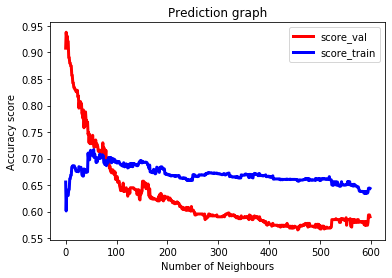

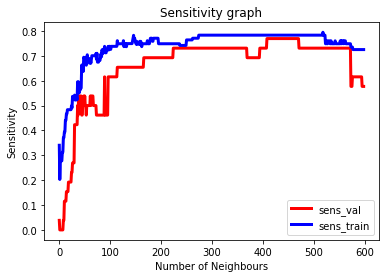

In [36]:
k_dict = {}
scores_train = {}
scores_val = {}
tp_val = {}
sens_train = {}
sens_val = {}
for k in range(1,600):
    clf = neighbors.KNeighborsClassifier(n_neighbors=k,algorithm = 'auto',metric = "manhattan")
    k_dict[k]=clf.fit(X_res_norm, y_res.values.ravel())
    y_pred_train = k_dict[k].predict(X_res_norm)
    y_pred_val = k_dict[k].predict(X_val_norm)
    scores_train[k] = accuracy_score(y_res, y_pred_train)
    scores_val[k] = accuracy_score(y_val, y_pred_val)
    tp_val[k] = confusion_matrix(y_val, y_pred)[1,1]
    sens_train[k] = confusion_matrix(y_res, y_pred_train)[1,1]/(confusion_matrix(y_res, y_pred_train)[1,1]+confusion_matrix(y_res, y_pred_train)[1,0])
    sens_val[k] = confusion_matrix(y_val, y_pred_val)[1,1]/(confusion_matrix(y_val, y_pred_val)[1,1]+confusion_matrix(y_val, y_pred_val)[1,0])
    
    
plt.figure(2)
plt.plot(list(scores_val.values()),'r',linewidth=3.0,label="score_val")
plt.plot(list(scores_train.values()),'b',linewidth=3.0,label="score_train")
plt.xlabel('Number of Neighbours')
plt.ylabel('Accuracy score')
plt.title('Prediction graph')
plt.legend()

plt.figure(3)
plt.plot(list(sens_val.values()),'r',linewidth=3.0,label="sens_val")
plt.plot(list(sens_train.values()),'b',linewidth=3.0,label="sens_train")
plt.xlabel('Number of Neighbours')
plt.ylabel('Sensitivity')
plt.title('Sensitivity graph')
plt.legend()
    
    
for key,value in scores_val.items():
    if value== max(scores_val.values()):
        keep_ac = key
        
print('Max neighbours for accuracy score = ',keep_ac)  

for key,value in tp_val.items():
    if value== max(tp_val.values()):
        keep_tp = key

print('Max neighbours for true positives = ',keep_tp)  

for key,value in sens_val.items():
    if value== max(sens_val.values()):
        keep_sens = key

print('Max neighbours for sensitivity = ',keep_sens)  


In [37]:
y_pred_test =  k_dict[keep_sens].predict(X_test_norm)
score = accuracy_score(y_test,y_pred_test)
print('Test score for κNN =',score)
tn_test, fp_test, fn_test, tp_test=confusion_matrix(y_test, y_pred_test).ravel()
print('Out of',y_test[y_test.Absent_next_period==1].shape[0],'absences, we predicted correctly',tp_test)

Test score for κNN = 0.5132275132275133
Out of 26 absences, we predicted correctly 23


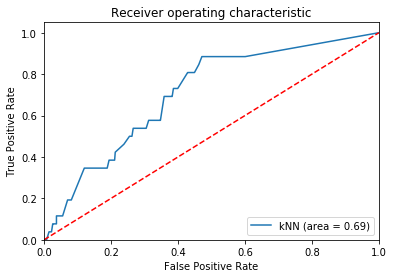

In [38]:
knn_roc_auc = roc_auc_score(y_test, k_dict[keep_sens].predict(X_test_norm))
fpr, tpr, thresholds = roc_curve(y_test, k_dict[keep_sens].predict_proba(X_test_norm)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='kNN (area = %0.2f)' % knn_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('kNN_ROC')
plt.show()

### 2.11 Undersampling Test

We thought that maybe the oversampling over the training dataset resulted in a problem of overfitting the models into the data (a common problem of oversampling). We then thought that we could try undersampling, which means basically to delete rows of the majority class of the dataset (non-absent employees) which the danger of deleting valuable information from the rows, in order to see if we have a better behaviour in the testing of the models.

In [39]:
under = RandomUnderSampler(random_state=42)
X_under, y_under = under.fit_resample(X_train, y_train)

X_under = pd.DataFrame(data=X_under,columns=X_train.columns)
y_under= pd.DataFrame(data=y_under,columns=['Absent_next_period'])

print(y_under[y_under.Absent_next_period==1].shape[0])
print(y_under[y_under.Absent_next_period==0].shape[0])

77
77


### 2.12 Decision Tree with Undersampling

In [40]:
decision_tree = tree.DecisionTreeClassifier(criterion="entropy")
decision_tree = decision_tree.fit(X_under.values, y_under.values)
y_pred = decision_tree.predict(X_val.values)
score = accuracy_score(y_val,y_pred)
print('With the default settings of the decision tree (trained on the resampled training dataset), the accuracy score on the validation dataset was',score)
tn, fp, fn, tp =confusion_matrix(y_val, y_pred).ravel()
print('Out of',y_val[y_val.Absent_next_period==1].shape[0],'absences, we predicted correctly',tp)

With the default settings of the decision tree (trained on the resampled training dataset), the accuracy score on the validation dataset was 0.6908127208480566
Out of 26 absences, we predicted correctly 10


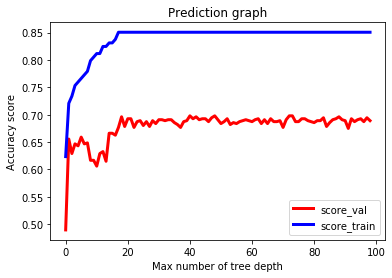

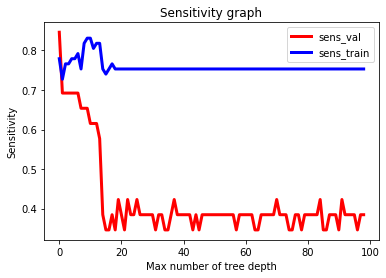

In [41]:
%matplotlib inline
d_dict = {}
scores_train ={}
scores_val = {}
tp_val={}
sens_train = {}
sens_val = {}
for d in range(1,100):
    decision_tree = tree.DecisionTreeClassifier(max_depth=d,criterion="entropy")
    d_dict[d] = decision_tree.fit(X_under.values, y_under.values)
    y_pred_val = d_dict[d].predict(X_val)
    y_pred_train = d_dict[d].predict(X_under)
    scores_train[d] = accuracy_score(y_under, y_pred_train)
    scores_val[d] = accuracy_score(y_val, y_pred_val)
    tp_val[d] = confusion_matrix(y_val, y_pred_val)[1,1]
    sens_train[d] = confusion_matrix(y_under, y_pred_train)[1,1]/(confusion_matrix(y_under, y_pred_train)[1,1]+confusion_matrix(y_under, y_pred_train)[1,0])
    sens_val[d] = confusion_matrix(y_val, y_pred_val)[1,1]/(confusion_matrix(y_val, y_pred_val)[1,1]+confusion_matrix(y_val, y_pred_val)[1,0])

plt.figure(1)
plt.plot(list(scores_val.values()),'r',linewidth=3.0,label="score_val")
plt.plot(list(scores_train.values()),'b',linewidth=3.0,label="score_train")
plt.xlabel('Max number of tree depth')
plt.ylabel('Accuracy score')
plt.title('Prediction graph')
plt.legend()

plt.figure(3)
plt.plot(list(sens_val.values()),'r',linewidth=3.0,label="sens_val")
plt.plot(list(sens_train.values()),'b',linewidth=3.0,label="sens_train")
plt.xlabel('Max number of tree depth')
plt.ylabel('Sensitivity')
plt.title('Sensitivity graph')
plt.legend()

In [42]:
for key,value in scores_val.items():
    if value== max(scores_val.values()):
        keep_ac = key
print('Max_depth for accuracy score = ',keep_ac)

for key,value in tp_val.items():
    if value== max(tp_val.values()):
        keep_tp = key
print('Max_depth for true positives = ',keep_tp)

for key,value in sens_val.items():
    if value== max(sens_val.values()):
        keep_sens = key
print('Max_depth for true positive rate (sensitivity) = ',keep_sens)

Max_depth for accuracy score =  74
Max_depth for true positives =  1
Max_depth for true positive rate (sensitivity) =  1


In [43]:
y_pred_test = d_dict[keep_sens].predict(X_test)
score = accuracy_score(y_test,y_pred_test)
print('Test score for Decision tree =',score)
tn_test, fp_test, fn_test, tp_test =confusion_matrix(y_test, y_pred_test).ravel()
print('Out of',y_test[y_test.Absent_next_period==1].shape[0],'absences, we predicted correctly',tp_test)

Test score for Decision tree = 0.47442680776014107
Out of 26 absences, we predicted correctly 23


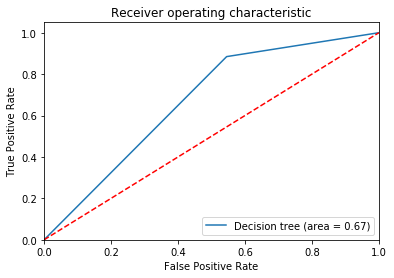

In [44]:
tree_roc_auc = roc_auc_score(y_test, d_dict[keep_sens].predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, d_dict[keep_sens].predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decision tree (area = %0.2f)' % tree_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('treeROC')
plt.show()

### 2.13 kNN with Undersampling

In [45]:
sc_X_under = StandardScaler()
X_under_norm = sc_X_under.fit_transform(X_under)
X_val_norm = sc_X_under.transform(X_val)
X_test_norm = sc_X_under.transform(X_test)

In [46]:
model = neighbors.KNeighborsClassifier(n_neighbors = 100, algorithm = 'auto', metric = 'manhattan')
model.fit(X_under_norm, y_under.values.ravel())
y_pred_test = model.predict(X_test_norm)

print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
score = metrics.accuracy_score(y_test, y_pred_test)
print('Test score for k nearest neighbours classifier =', score)
tn_test, fp_test, fn_test, tp_test=confusion_matrix(y_test, y_pred_test).ravel()
print('Out of',y_test[y_test.Absent_next_period==1].shape[0],'absences, we predicted correctly',tp_test)

              precision    recall  f1-score   support

           0       0.98      0.43      0.60       541
           1       0.06      0.81      0.12        26

    accuracy                           0.45       567
   macro avg       0.52      0.62      0.36       567
weighted avg       0.94      0.45      0.57       567

[[232 309]
 [  5  21]]
Test score for k nearest neighbours classifier = 0.4462081128747795
Out of 26 absences, we predicted correctly 21


Max neighbours for accuracy score =  152
Max neighbours for true positives =  153
Max neighbours for sensitivity=  95


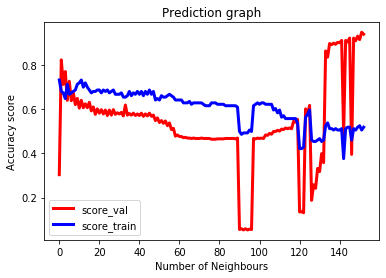

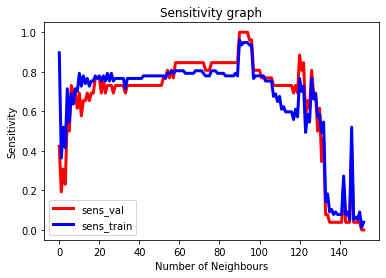

In [47]:
k_dict = {}
scores_train = {}
scores_val = {}
tp_val = {}
sens_train = {}
sens_val = {}
for k in range(1,154):
    clf = neighbors.KNeighborsClassifier(n_neighbors=k,algorithm = 'auto',metric = "manhattan")
    k_dict[k]=clf.fit(X_under_norm, y_under.values.ravel())
    y_pred_train = k_dict[k].predict(X_under_norm)
    y_pred_val = k_dict[k].predict(X_val_norm)
    scores_train[k] = accuracy_score(y_under, y_pred_train)
    scores_val[k] = accuracy_score(y_val, y_pred_val)
    tp_val[k] = confusion_matrix(y_val, y_pred)[1,1]
    sens_train[k] = confusion_matrix(y_under, y_pred_train)[1,1]/(confusion_matrix(y_under, y_pred_train)[1,1]+confusion_matrix(y_under, y_pred_train)[1,0])
    sens_val[k] = confusion_matrix(y_val, y_pred_val)[1,1]/(confusion_matrix(y_val, y_pred_val)[1,1]+confusion_matrix(y_val, y_pred_val)[1,0])
    
    
plt.figure(2)
plt.plot(list(scores_val.values()),'r',linewidth=3.0,label="score_val")
plt.plot(list(scores_train.values()),'b',linewidth=3.0,label="score_train")
plt.xlabel('Number of Neighbours')
plt.ylabel('Accuracy score')
plt.title('Prediction graph')
plt.legend()

plt.figure(3)
plt.plot(list(sens_val.values()),'r',linewidth=3.0,label="sens_val")
plt.plot(list(sens_train.values()),'b',linewidth=3.0,label="sens_train")
plt.xlabel('Number of Neighbours')
plt.ylabel('Sensitivity')
plt.title('Sensitivity graph')
plt.legend()
    
    
for key,value in scores_val.items():
    if value== max(scores_val.values()):
        keep_ac = key
print('Max neighbours for accuracy score = ',keep_ac)   

for key,value in tp_val.items():
    if value== max(tp_val.values()):
        keep_tp = key
        
print('Max neighbours for true positives = ',keep_tp)
        
for key,value in sens_val.items():
    if value== max(sens_val.values()):
        keep_sens = key
        
print('Max neighbours for sensitivity= ',keep_sens)

In [48]:
y_pred_test =  k_dict[10].predict(X_test_norm)
score = accuracy_score(y_test,y_pred_test)
print('Test score for κNN =',score)
tn_test, fp_test, fn_test, tp_test=confusion_matrix(y_test, y_pred_test).ravel()
print('Out of',y_test[y_test.Absent_next_period==1].shape[0],'absences, we predicted correctly',tp_test)

Test score for κNN = 0.6190476190476191
Out of 26 absences, we predicted correctly 19


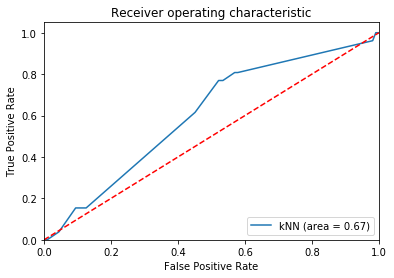

In [49]:
knn_roc_auc = roc_auc_score(y_test, k_dict[10].predict(X_test_norm))
fpr, tpr, thresholds = roc_curve(y_test, k_dict[keep_sens].predict_proba(X_test_norm)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='kNN (area = %0.2f)' % knn_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('kNN_ROC')
plt.show()

# Part III: Employee Categorisation using Clustering

In [3]:
style.use("ggplot")

### 3.1 Preprocessing

#### 3.1.1 Import and Examine Data

In [4]:
df = pd.read_csv('../Datasets/workforce_dataset.csv').fillna(0)
df[:3]

employee  No_of_Votes  Average_value_Votes  Emotional_stability  \
0  2ER      15.0         2.2                  1.0                   
1  DaW      14.0         3.0                  0.0                   
2  5ER      14.0         1.0                  0.0                   

   No_of_Comments  Likes_from_others  Dislikes_from_others  \
0  1.0             53.0               5.0                    
1  0.0             0.0                0.0                    
2  1.0             49.0               11.0                   

   Absent_next_period                      Current_Period  
0  1                     FROM  2018-05-15  TO  2018-05-31  
1  0                     FROM  2018-05-15  TO  2018-05-31  
2  0                     FROM  2018-05-15  TO  2018-05-31

In [5]:
X = df.copy().drop(columns=['employee','Current_Period'])

##### Statistical Summary

In [6]:
X.describe()

No_of_Votes  Average_value_Votes  Emotional_stability  No_of_Comments  \
count  2832.000000  2832.000000          2832.000000          2832.000000      
mean   5.407133     1.688951             0.311441             0.168785         
std    5.672057     1.559843             0.707559             0.883804         
min    0.000000     0.000000             0.000000             0.000000         
25%    0.000000     0.000000             0.000000             0.000000         
50%    3.000000     2.000000             0.000000             0.000000         
75%    11.000000    3.000000             0.000000             0.000000         
max    16.000000    4.000000             3.000000             18.000000        

       Likes_from_others  Dislikes_from_others  Absent_next_period  
count  2832.000000        2832.000000           2832.000000         
mean   2.686794           1.069915              0.045551            
std    14.363884          6.690835              0.208546            
min    0.000000           0.000000              0.000000            
25%    0.000000           0.000000              0.000000            
50%    0.000000           0.000000              0.000000            
75%    0.000000           0.000000              0.000000            
max    260.000000         148.000000            1.000000

##### Feature Correlations

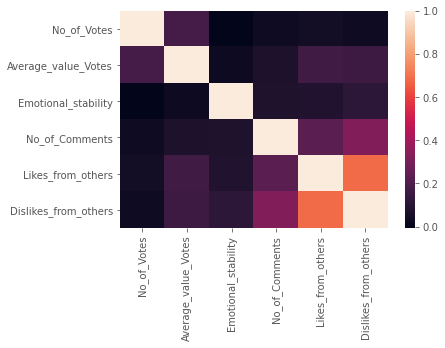

In [7]:
df_cor =  X.drop(columns=['Absent_next_period']).apply(lambda x: x.factorize()[0]).corr()
sns.heatmap(df_cor)
plt.show()

'Likes_from_others' and 'Dislikes_from_others' highly correlated, however, K-means generally unnaffected by highly correlated features hence can leave these in.

##### Feature Distributions

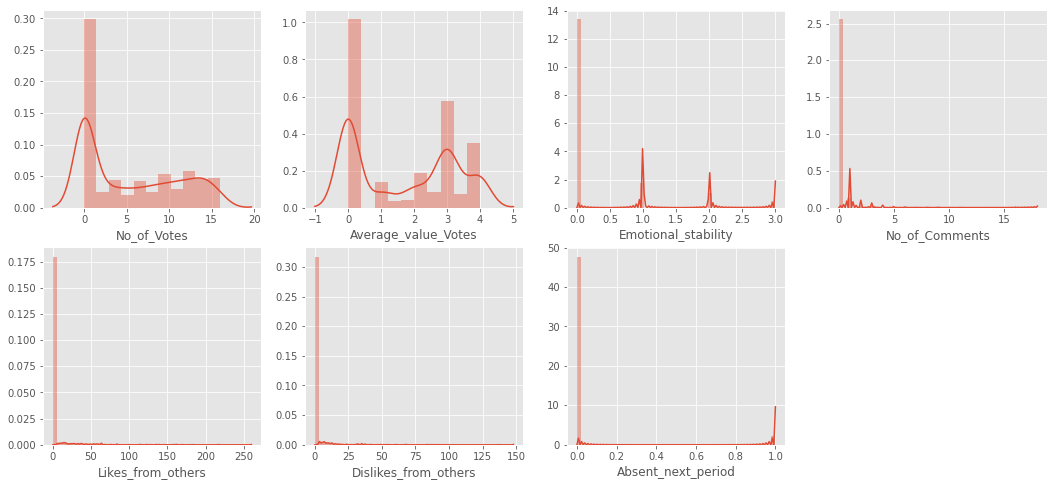

In [8]:
plt.figure(figsize=(18,8))
for i, v in enumerate(X.columns.values):
    plt.subplot(240+i+1)
    ax = sns.distplot(X[v], kde=True)
plt.show()

#### 3.1.2 Scaling
Cannot use the standard scaler as features are not normally distributed. There is still variation in the feature scales, however, so we normalise.

In [9]:
scaler = MinMaxScaler() 
X_scaled = scaler.fit_transform(X)

### 3.2 Hyperparameter Tuning
#### 3.2.1 Optimum K Selection
##### Elbow and Silhouette Score

In [10]:
def ElbowSilhouetteScores(X_scaled, n=15):
    distortions, silhouette = [], []

    for i in range(2, n):
        km = KMeans(
            n_clusters=i, init='k-means++',
            n_init=10, max_iter=300,
            tol=1e-04, random_state=0
        )

        km.fit(X_scaled)
        distortions.append(km.inertia_)
        silhouette.append(metrics.silhouette_score(X_scaled, km.labels_))
        
    return distortions, silhouette

##### Cluster Stability (Brittleness)

In [11]:
def ClusterStability(X_scaled, mode, n=15):
    stability_scores = []
    
    # Split dataset in half
    x1 = X_scaled[:round(len(X_scaled)/2), :]
    x2 = X_scaled[round(len(X_scaled)/2):, :]

    for i in range(2, n):
        # Fit KMeans with i clusters
        if mode == 'ncluster':
            km_stab = KMeans(
                n_clusters=i, init='k-means++',
                n_init=10, max_iter=300, 
                tol=1e-04, random_state=0
            )
        
        # Fit KMeans with i random_state
        elif mode == 'nrs':
            km_stab = KMeans(
                n_clusters=4, init='k-means++',
                n_init=10, max_iter=300, 
                tol=1e-04, random_state=i**2
            )

        # Get cluster predictions for x1 and full x data
        y_km_X = km_stab.fit_predict(X_scaled)
        y_km_x1 = km_stab.fit_predict(x1)

        # Assign x2 to nearest centroid
        centroid_stab = km_stab.cluster_centers_
        distances = pairwise_distances(x2,centroid_stab)
        y_km_x2 = [np.where(i == np.amin(i))[0][0] for i in distances]

        # Get accuracy (stability)
        stab_comp = Counter(y_km_X == list(y_km_x1)+y_km_x2)
        stability_scores.append(stab_comp[True]/sum(stab_comp.values()))

    return stability_scores

##### Shuffling
K-means is sensitive to starting order hence we shuffle the data 10 times and take the average scores.

In [12]:
for i in tqdm(range(10)):
    X_scaled_shuff, n = shuffle(X_scaled, random_state=i**2), 15

    distortions, silhouette = ElbowSilhouetteScores(X_scaled_shuff)
    stability_scores = ClusterStability(X_scaled_shuff,'ncluster')
    
    if i == 0:
        df_dis = pd.DataFrame([distortions])
        df_sil = pd.DataFrame([silhouette])
        df_sta = pd.DataFrame([stability_scores])
        
    else:
        df_dis = df_dis.append([distortions])
        df_sil = df_sil.append([silhouette])
        df_sta = df_sta.append([stability_scores])

df_scores = pd.DataFrame({
    'inertia':df_dis.transpose().mean(axis=1),
    'silhouette':df_sil.transpose().mean(axis=1),
    'stability':df_sta.transpose().mean(axis=1)
})

df_scores.to_csv('scores.csv', index=False, encoding='utf-8')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:16<00:00,  7.67s/it]


In [13]:
df_scores = pd.read_csv('scores.csv', encoding='utf-8')
scores = scaler.fit_transform(df_scores)

Plot results.

In [14]:
fig = make_subplots()

fig.add_trace(
    go.Scatter(x=list(range(2,n)), y=scores[:,0], name="Distortion")
)

fig.add_trace(
    go.Scatter(x=list(range(2,n)), y=scores[:,1], name="Silhouette Score")
)

fig.add_trace(
    go.Scatter(x=list(range(2,n)), y=scores[:,2], name="Stability")
)

fig.update_xaxes(title_text='Number of Clusters')
fig.update_yaxes(title_text="Normalised Scores")
fig.layout.template = 'ggplot2'
fig.show()

#### 3.2.2 Optimum Centroid Initialisation
K-means is a heuristic and hence finds a local maxima which is highly dependent on the centroid starting positions dictated by the random_state. As we normalised our values lets find the true stability of the clusters.

In [15]:
round(df_scores['stability'][2],3)

0.381

Since the stability is low, we vary the will vary the random state to try find a higher local maxima.

In [16]:
stability = ClusterStability(X_scaled_shuff,'nrs')
print('Maximum stability: ',round(max(stability),3))
print('Random state: ',stability.index(max(stability))**2)

Maximum stability:  0.998
Random state:  25


### 3.3 Fit with Optimum Number of Clusters
Highest stability other than 1.

In [17]:
n_clusters = 4

km = KMeans(
    n_clusters=n_clusters, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=25
)

y_km = km.fit_predict(X_scaled)
df['cluster'] = y_km

### 3.4 Cluster Evaluation

Percentage absent per cluster.

In [18]:
percent_absent, pa = df.groupby(['cluster','Absent_next_period']).count()['employee'], []
                       
for i in range(n_clusters):
    try: pa.append(round(percent_absent[i][1]/percent_absent[i][0],2))         
    except: pa.append(percent_absent[i].index[0])

Aggregate by cluster.

In [19]:
cluster_data = df.groupby('cluster').mean()
cluster_data['Absent_next_period'] = pa
cluster_data.append(X.describe().loc['mean',])

No_of_Votes  Average_value_Votes  Emotional_stability  \
cluster                                                          
0        6.922481     2.271395             0.418605              
1        12.353078    2.706876             0.837398              
2        5.407576     3.195758             0.156061              
3        0.181895     0.042538             0.003384              
mean     5.407133     1.688951             0.311441              

         No_of_Comments  Likes_from_others  Dislikes_from_others  \
cluster                                                            
0        0.201550        2.589147           0.697674               
1        0.435540        7.051103           2.997677               
2        0.110606        1.565152           0.487879               
3        0.003384        0.144670           0.031303               
mean     0.168785        2.686794           1.069915               

         Absent_next_period  
cluster                      
0        1.000000            
1        0.000000            
2        0.000000            
3        0.000000            
mean     0.045551

Pie chart.

In [20]:
fig = go.Figure(data=[go.Pie(values=list(Counter(y_km).values()),
                             labels=list(Counter(y_km).keys()),
                             textinfo='percent',
                             textfont=dict(color="white"),
                             textposition='inside')])

fig.layout.template = 'ggplot2'
fig.show()

Radar plots.

In [21]:
radar_data = scaler.fit_transform(cluster_data.abs())

In [22]:
layouts = [[1,1],[1,2],[2,1],[2,2]]
colours = ['rgba(255,0,0,','rgba(0,204,102,','rgba(255,102,255,','rgba(0,255,255,']
fig = make_subplots(rows=2, cols=2, specs=[[{'type': 'polar'}]*2]*2)

for i in range(len(radar_data)): 
    r0 = radar_data[i]
    theta0 = cluster_data.columns.values
    
    fig.add_trace(go.Scatterpolar(
        name = str(i),
        r = np.append(r0,r0[0]),
        theta = np.append(theta0,theta0[0]),
        mode = 'lines',
        line = dict(color=colours[i]+'1)'),
        fillcolor = colours[i]+'0.4)'
        ),
    layouts[i][0], layouts[i][1]
    )    
    
fig.update_layout(
    polar = dict(
        radialaxis = dict(showticklabels=False, ticks=''),
        angularaxis = dict(showticklabels=True, ticks='')
    ),
    polar2 = dict(
        radialaxis = dict(showticklabels=False, ticks=''),
        angularaxis = dict(showticklabels=False, ticks='')
    ),
    polar3 = dict(
        radialaxis = dict(showticklabels=False, ticks=''),
        angularaxis = dict(showticklabels=False, ticks='')
    ),
    polar4 = dict(
        radialaxis = dict(showticklabels=False, ticks=''),
        angularaxis = dict(showticklabels=True, ticks='')
    )    
)
    
fig.update_traces(fill='toself')
fig.layout.template = 'ggplot2'
fig.show()

##### Cluster 0: Absentees 
    - Smallest proportion of the company
    - More involved than average with surveys
    - Liked by other employees (lower than average dislikes)
    - All have been absent
     
##### Cluster 1: Highly active
    - Highly participative in the surveys with scores well above average
    - Approximately 1/3 of the company 
    - Never absent
    
##### Cluster 2: Standard employee
    - Engage with surveys at an average level
    - Approximately 1/4 of the company
    - Never absent
     
##### Cluster 3: Non-survey participants
    - Majority of the company
    - Rarely participate in surveys hence hard to track or assess
    - Never absent

### 3.5 2-D Cluster Visualisation
Examine explained variance using Principal Components Analysis.

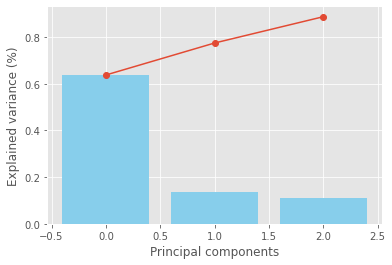

In [23]:
for i in range(1,4):
    pca = PCA(n_components=i)
    pca.fit(X_scaled)
    
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, 
        label='Individual', color='skyblue')

plt.plot(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_.cumsum(), 
         label='Cumulative', marker='o')

plt.ylabel('Explained variance (%)', fontsize=12)
plt.xlabel('Principal components', fontsize=12)
plt.show()

Fit with 2 components for 2-D visualisation.

In [24]:
pca = PCA(n_components=2)
pca.fit(X_scaled)
X_2d = pca.transform(X_scaled)
centroids = pca.transform(km.cluster_centers_)

Plot clusters.

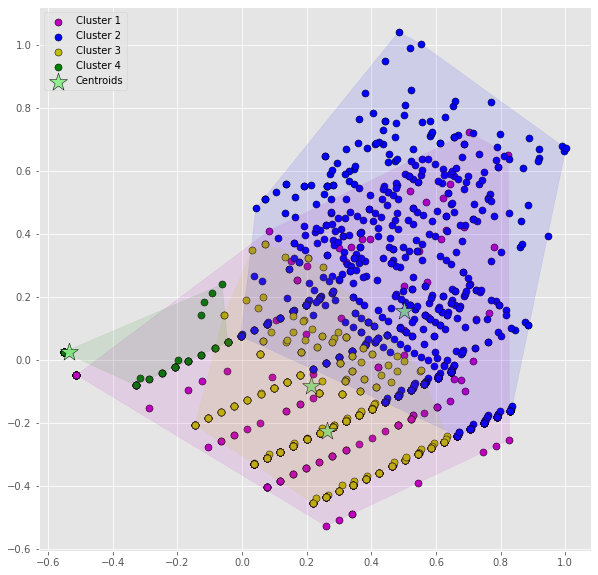

In [25]:
width, height = zip(*X_2d)
ratio = round((max(width)-min(width))/(max(height)-min(height)),2)
plt.figure(figsize=(10*ratio,10))

colours = ['m','b','y','g']

for i in range(len(set(y_km))):
    x = X_2d[y_km == i, 0]
    y = X_2d[y_km == i, 1]
    hull = ConvexHull(list(zip(x, y)))
    
    plt.scatter(
        x, y,
        color=colours[i],
        s=50, marker='o', 
        edgecolor='black',
        label='Cluster '+str(i+1)
    )
    
    plt.fill(
        x[hull.vertices], y[hull.vertices], 
        alpha=0.1, color=colours[i]
    )
 
# Centroids
plt.scatter(
    centroids[:, 0], centroids[:, 1],
    s=350, marker='*', c='lightgreen', 
    edgecolor='black',
    label='Centroids'
)

plt.legend()
plt.show()

Unfortunately, despite a relatively high explained variance with two components, the cluster boundaries are difficult to visualise in 2-D. 